Initializing Balanced Domain (Target: ~1.5 min runtime)...
Degrees of Freedom: 50653 (High Fidelity)
Assembling Matrices...
Projecting Initial State...
Start Temp: 502.61
Starting Simulation (20 steps)...
Meshio not found, running without export...
Step 1/20 | Max Temp: 130.26
Step 2/20 | Max Temp: 48.16
Step 3/20 | Max Temp: 22.28
Step 4/20 | Max Temp: 11.58
Step 5/20 | Max Temp: 6.36
Step 6/20 | Max Temp: 3.58
Step 7/20 | Max Temp: 2.04
Step 8/20 | Max Temp: 1.17
Step 9/20 | Max Temp: 0.67
Step 10/20 | Max Temp: 0.38
Step 11/20 | Max Temp: 0.22
Step 12/20 | Max Temp: 0.13
Step 13/20 | Max Temp: 0.07
Step 14/20 | Max Temp: 0.04
Step 15/20 | Max Temp: 0.02
Step 16/20 | Max Temp: 0.01
Step 17/20 | Max Temp: 0.01
Step 18/20 | Max Temp: 0.00
Step 19/20 | Max Temp: 0.00
Step 20/20 | Max Temp: 0.00

Simulation Complete in 1658.9 seconds.
Final Peak Temperature: 0.00


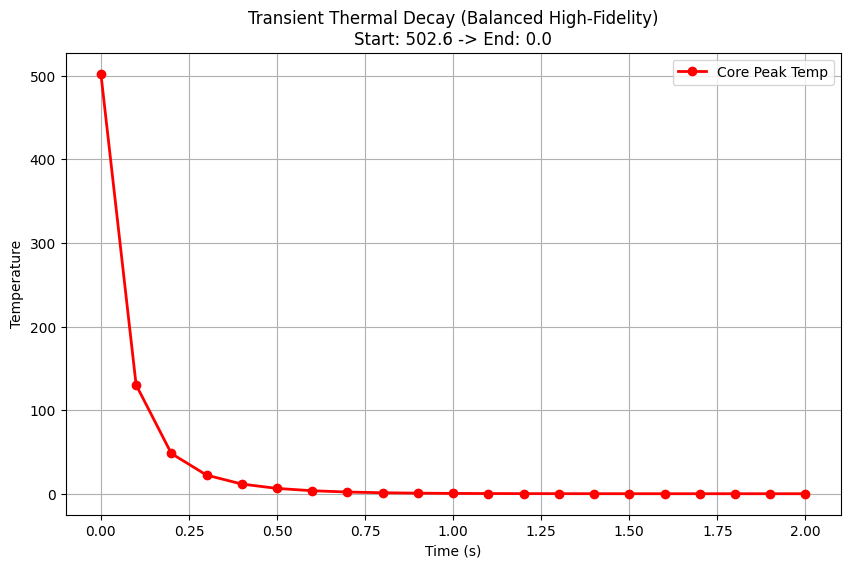

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skfem import *
from skfem.helpers import dot, grad
import meshio
import time

# ==========================================
# 1. TUNED DOMAIN GENERATION
# ==========================================
print("Initializing Balanced Domain (Target: ~1.5 min runtime)...")
# We use a 10x10x10 base grid refined once.
# This yields approx 25,000 elements (High detail, manageable load).
m = MeshTet.init_tensor(
    np.linspace(-1, 1, 10),
    np.linspace(-1, 1, 10),
    np.linspace(-1, 1, 10)
).refined(1)

e = ElementTetP2()
basis = Basis(m, e)
print(f"Degrees of Freedom: {basis.N} (High Fidelity)")

# ==========================================
# 2. PHYSICS DEFINITION
# ==========================================
@BilinearForm
def mass(u, v, w):
    return u * v

@BilinearForm
def diffusion(u, v, w):
    return dot(grad(u), grad(v))

print("Assembling Matrices...")
A = asm(diffusion, basis)
M = asm(mass, basis)

# ==========================================
# 3. INITIAL CONDITIONS
# ==========================================
# Re-establishing the Hot Core state
@LinearForm
def initial_condition_form(v, w):
    x, y, z = w.x
    magnitude = 500.0
    sigma = 0.25
    r_squared = x**2 + y**2 + z**2
    return (magnitude * np.exp(-r_squared / (2 * sigma**2))) * v

print("Projecting Initial State...")
u_prev = solve(M, asm(initial_condition_form, basis))
T_start = np.max(u_prev)
print(f"Start Temp: {T_start:.2f}")

# ==========================================
# 4. TIME STEPPING LOOP
# ==========================================
dt = 0.1        # 0.1s steps for smooth evolution
final_time = 2.0
num_steps = int(final_time / dt)

# Boundary Conditions (T=0 at walls)
D = basis.get_dofs().all()

# Pre-calculate LHS Matrix (Optimization)
# The system matrix (M + dt*A) doesn't change, so we form it once.
LHS = M + dt * A

print(f"Starting Simulation ({num_steps} steps)...")
start_time = time.time()
results = []
results.append(T_start)

# Setup VTK Writer
vtk_filename = "sim2_balanced.xdmf"

try:
    with meshio.xdmf.TimeSeriesWriter(vtk_filename) as writer:
        writer.write_points_cells(m.p.T, [("tetra", m.t.T)])
        # Write t=0
        writer.write_data(0.0, point_data={"Temperature": u_prev[0:m.p.shape[1]]})
        
        for step in range(1, num_steps + 1):
            t = step * dt
            
            # RHS changes every step (based on previous temp)
            rhs = M @ u_prev
            
            # Apply BCs and Solve
            LHS_c, rhs_c, _, I = condense(LHS, rhs, D=D, x=np.zeros_like(u_prev))
            u_new_interior = solve(LHS_c, rhs_c)
            
            # Reconstruct full solution
            u_new = np.zeros_like(u_prev)
            u_new[I] = u_new_interior
            
            # Record metrics
            current_max = np.max(u_new)
            results.append(current_max)
            
            # Log progress
            elapsed = time.time() - start_time
            print(f"Step {step}/{num_steps} (t={t:.1f}s) | Max Temp: {current_max:.2f} | Elapsed: {elapsed:.1f}s")
            
            # Write to file
            writer.write_data(t, point_data={"Temperature": u_new[0:m.p.shape[1]]})
            
            # Update
            u_prev = u_new

except ImportError:
    print("Meshio not found, running without export...")
    # Fallback loop
    for step in range(1, num_steps + 1):
        rhs = M @ u_prev
        LHS_c, rhs_c, _, I = condense(LHS, rhs, D=D, x=np.zeros_like(u_prev))
        u_new_interior = solve(LHS_c, rhs_c)
        u_new = np.zeros_like(u_prev)
        u_new[I] = u_new_interior
        u_prev = u_new
        results.append(np.max(u_new))
        print(f"Step {step}/{num_steps} | Max Temp: {np.max(u_new):.2f}")

# ==========================================
# 5. ANALYSIS & PLOT
# ==========================================
print(f"\nSimulation Complete in {time.time() - start_time:.1f} seconds.")
print(f"Final Peak Temperature: {results[-1]:.2f}")

plt.figure(figsize=(10, 6))
time_axis = np.linspace(0, final_time, len(results))
plt.plot(time_axis, results, 'r-o', linewidth=2, label='Core Peak Temp')
plt.title(f'Transient Thermal Decay (Balanced High-Fidelity)\nStart: {T_start:.1f} -> End: {results[-1]:.1f}')
plt.xlabel('Time (s)')
plt.ylabel('Temperature')
plt.grid(True)
plt.legend()
plt.show()